# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#only if you have jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Download Cifar10 dataset

In [2]:
torch.cuda.is_available()

False

In [3]:
DATA_PATH = './data'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [5]:
train_loader.batch_size

64

In [6]:
#for i, (x, y) in enumerate(train_loader):
#    print(x, y)

### Using  GPUs

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')

else:
    device = torch.device('cpu')
print(device)

cpu


### Mostrar imágenes

La imagen muestreada representa un: frog


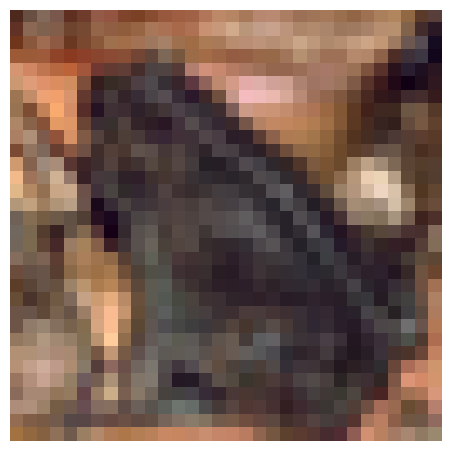

In [8]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


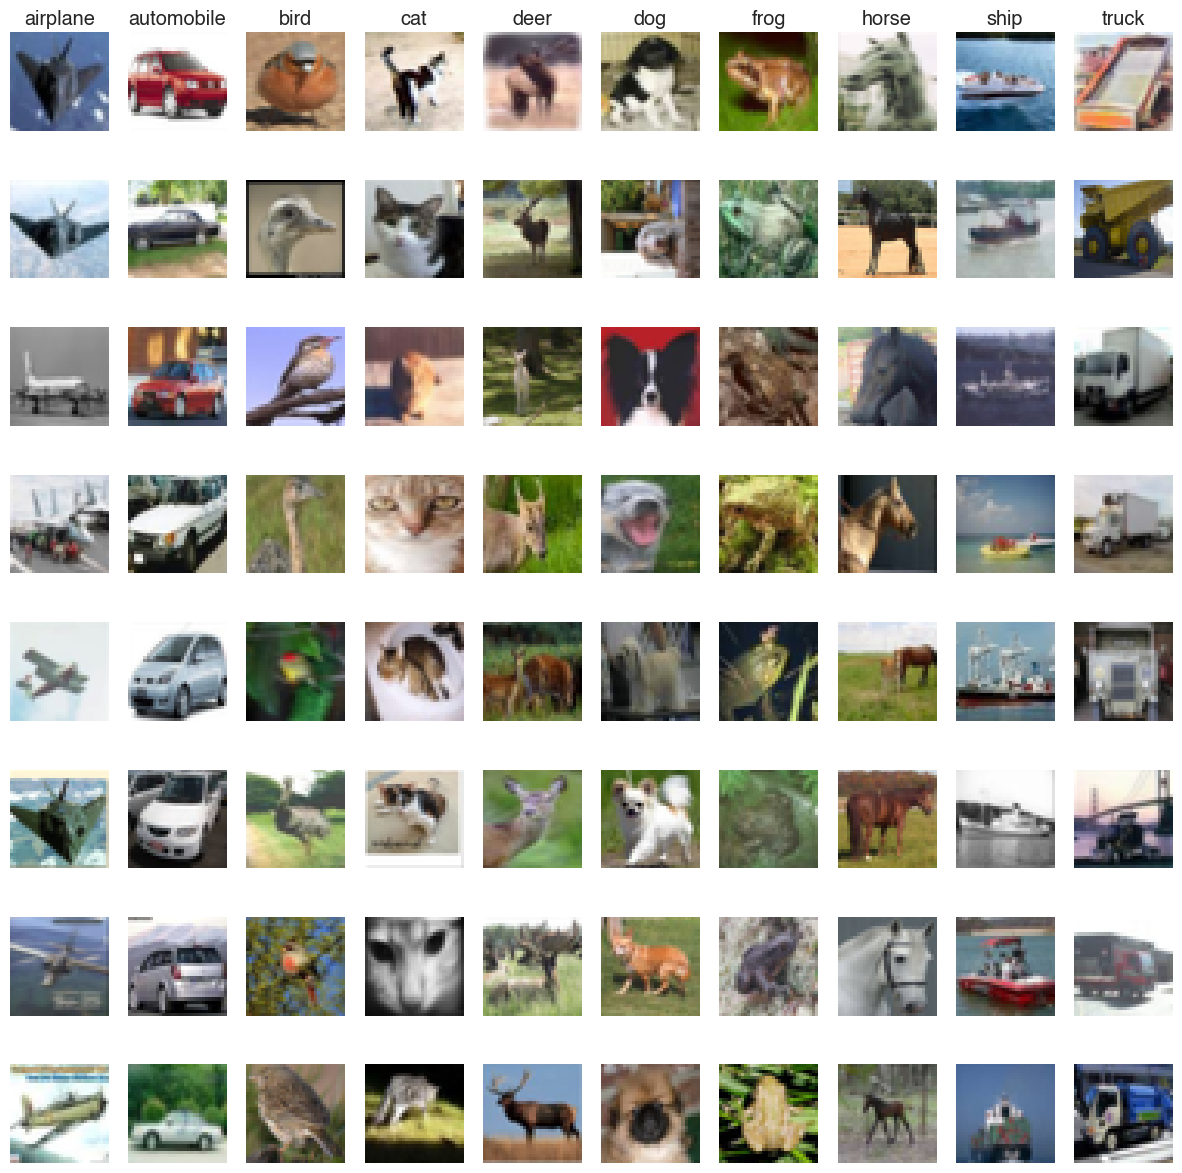

In [9]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 

### Calcular accuracy


In [10]:
def accuracy(model, loader):
# To do: Code your accuracy function
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct // total

### Loop de entrenamiento

In [11]:
def train(model, optimiser, epochs=100):

    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimiser.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        # get accuracy
        acc = accuracy(model, train_loader)
        val_acc = accuracy(model, val_loader)

        print(f'epoch: {epoch + 1} loss: {running_loss / 2000:.3f} accuracy: {acc:.3f} val_accuracy: {val_acc:.3f}')
        running_loss = 0.0


    print('Finished Training')

### Linear model

In [12]:
# To do: Use PyTorch to create a linear model to have an initial baseline model
# Define a simple linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(3 * 32 * 32, 10)  # 3 channels, each image is 32x32 pixels, 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc(x)
        return x

model1 = LinearModel()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

In [13]:
train(model1, optimizer, epochs=10)

epoch: 1 loss: 0.730 accuracy: 38.000 val_accuracy: 37.000
epoch: 2 loss: 0.697 accuracy: 40.000 val_accuracy: 39.000
epoch: 3 loss: 0.687 accuracy: 41.000 val_accuracy: 39.000
epoch: 4 loss: 0.681 accuracy: 42.000 val_accuracy: 40.000
epoch: 5 loss: 0.678 accuracy: 41.000 val_accuracy: 39.000
epoch: 6 loss: 0.674 accuracy: 42.000 val_accuracy: 39.000
epoch: 7 loss: 0.669 accuracy: 42.000 val_accuracy: 39.000
epoch: 8 loss: 0.667 accuracy: 43.000 val_accuracy: 41.000
epoch: 9 loss: 0.666 accuracy: 41.000 val_accuracy: 39.000
epoch: 10 loss: 0.665 accuracy: 43.000 val_accuracy: 40.000
Finished Training


### Sequential CNN

In [70]:
# To do: Use PyTorch to implement a CNN model, accuracy should be better than 
#the linear model
# Define a CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Pooling Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Pooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Pooling Layer 3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layer 1
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # Fully Connected Layer 2 (output)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Pass through the first convolutional layer
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        # Pass through the second convolutional layer
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        # Pass through the third convolutional layer
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        # Flatten before fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        # Pass through the first fully connected layer
        x = F.relu(self.fc1(x))
        # Pass through the output layer
        x = self.fc2(x)
        return x


In [ ]:
# Create an instance of the CNN model
modelCNN1 = CNNModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN1.parameters(), lr=0.001, momentum=0.9)
train(modelCNN1, optimizer, 15)